# U-Net - Classification

In [1]:
import tensorflow as tf
import os
import random
import numpy as np
 
from tqdm import tqdm 

from skimage.io import imread, imshow
from skimage.transform import resize
from skimage.measure import label, regionprops
from skimage.util import random_noise

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split


from tensorflow import keras
from datetime import datetime

from keras import layers, metrics


from tensorboard.plugins.hparams import api as hp


from sklearn.metrics import jaccard_score

In [2]:
date = "24_05_18"

In [3]:
def display(display_list):
  plt.figure(figsize=(8, 8))

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    if i == 1:
      plt.imshow(display_list[i], cmap='gray',  interpolation='nearest')
    elif i == 2:
      plt.imshow(display_list[i], cmap='jet',  interpolation='nearest')
    else:
      plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()

In [4]:
hyper_param_channels = 2
hyper_param_learning_rate = 0.001
hyper_param_batch_size = 100
hyper_param_epochs = 70
hyper_param_image_size = 1

#image dimensions, seems to work with non-square inputs
IMAGE_CHANNELS = 3

IMAGE_HEIGHT =  192*hyper_param_image_size
IMAGE_WIDTH = 64*hyper_param_image_size

seed = 4
np.random.seed = seed
random.seed(seed)
tf.random.set_seed(seed)

DATA_TRAIN = "./datasets/KolektorSDD2/train/"
DATA_TEST = "./datasets/KolektorSDD2/test/"

train_ids = next(os.walk(os.path.join(DATA_TRAIN, "images/")))[2]
test_ids = next(os.walk(os.path.join(DATA_TEST, "images/")))[2]

damaged = [] # prepare for data augmentation
damaged_mask = []

X_train = np.zeros((len(train_ids), IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS), dtype=np.float16)
y_train = np.zeros((len(train_ids), IMAGE_HEIGHT, IMAGE_WIDTH), dtype=np.float16)

print('Resizing training images and masks')

for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):   
    path = DATA_TRAIN 

    img = imread(path + 'images/' + id_)[:,:,:IMAGE_CHANNELS]  
    img = resize(img, (IMAGE_HEIGHT, IMAGE_WIDTH), mode='constant', preserve_range=True)
    img /= 255.0
    X_train[n] = img  #Fill empty X_train with values from img

    mask = np.zeros((IMAGE_HEIGHT, IMAGE_WIDTH, 1), dtype=bool)
    mask_file = os.path.join(path + 'masks/' + id_[:5] + "_GT.png")
    mask = imread(mask_file)[:,:]

    mask = resize(mask, (IMAGE_HEIGHT, IMAGE_WIDTH), mode='constant', preserve_range=True)
    mask /= 255.0  
    mask = np.where(mask > 0.5, 1.0, 0.0) 
    y_train[n] = mask 

    if np.count_nonzero(mask) != 0:
        damaged.append(img)
        damaged_mask.append(mask)
    
# test images
test_images = np.zeros((len(test_ids), IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS), dtype=np.float16)
test_masks = np.zeros((len(test_ids), IMAGE_HEIGHT, IMAGE_WIDTH), dtype=np.float16)

sizes_test = []
print('Resizing test images') 
for n, id_ in tqdm(enumerate(test_ids), total=len(test_ids)):
    path = DATA_TEST
    img = imread(path + '/images/' + id_ )[:,:,:IMAGE_CHANNELS]
    sizes_test.append([img.shape[0], img.shape[1]])
    img = resize(img, (IMAGE_HEIGHT, IMAGE_WIDTH), mode='constant', preserve_range=True)
    img /= 255.0
    test_images[n] = img

    mask = np.zeros((IMAGE_HEIGHT, IMAGE_WIDTH, 1), dtype=bool)
    mask_file = os.path.join(path + 'masks/' + id_[:5] + "_GT.png")
    mask = imread(mask_file)[:,:]

    mask = resize(mask, (IMAGE_HEIGHT, IMAGE_WIDTH), mode='constant', preserve_range=True)
    mask /= 255.0     
    mask = np.where(mask > 0.5, 1.0, 0.0)   
    test_masks[n] = mask 

## Data augmentation - rotate and flip images
vertical_train = np.flip(damaged, axis=0)
vertical_test = np.flip(damaged_mask, axis=0)

horizontal_train = np.flip(damaged, axis=1)
horizontal_test = np.flip(damaged_mask, axis=1)

rotating_train = np.rot90(damaged, k=2)
rotating_test = np.rot90(damaged_mask, k=2)

vert_rot_train = np.rot90(vertical_train, k=2)
vert_rot_test = np.rot90(vertical_test, k=2)

hor_rot_train = np.rot90(horizontal_train, k=2)
hor_rot_test = np.rot90(horizontal_test, k=2)

# Done with rotation
Boxes = []
check = []
for img in damaged_mask:
    labels = label(img)
    regions = regionprops(labels)
    if len(regions) == 1:
        check.append(1)
        for props in regions:
            min_x, min_y, max_x, max_y = props.bbox
            Boxes.append((min_x, min_y, max_x, max_y))
    else:
        check.append(0)

# Throw out images, which have more than one damage
onedamage = [damaged[i] for i in range(len(damaged)) if check[i] == 1]
onedamage_mask = [damaged_mask[i] for i in range(len(damaged_mask)) if check[i] == 1]

def crop_image(image, bbox):
    # Crop the image using NumPy array slicing
    cropped_image = image[bbox[0]:bbox[2], bbox[1]:bbox[3]]
    return cropped_image

def overlay_image(background, background_mask, overlay, overlay_mask):
    # Generate random position for overlay image
    if overlay.shape[1] < background.shape[1]:
        x_offset = np.random.randint(0, background.shape[1] - overlay.shape[1])
        y_offset = np.random.randint(0, background.shape[0] - overlay.shape[0])
    
        # Overlay the image
        background[y_offset:y_offset + overlay.shape[0], x_offset:x_offset + overlay.shape[1]] = overlay
        background_mask[y_offset:y_offset + overlay_mask.shape[0], x_offset:x_offset + overlay_mask.shape[1]] = overlay_mask
        return background, background_mask
    else:
        return background, background_mask

generated_img = np.empty((len(onedamage),IMAGE_HEIGHT,IMAGE_WIDTH,3))
generated_mask = np.empty((len(onedamage), IMAGE_HEIGHT,IMAGE_WIDTH))
overlayed_indices = []
for i, image in enumerate(onedamage):
    # Get the bounding box for the current image
    bbox = Boxes[i]
    mask = onedamage_mask[i]
    # Crop the image
    cropped_image = crop_image(image, bbox)
    cropped_mask = crop_image(mask, bbox)
    # Pick a random overlay image from the list
    overlay_image_index = np.random.choice([idx for idx in range(len(X_train)) if idx not in overlayed_indices])
    overlay = X_train[overlay_image_index]
    overlay_mask = y_train[overlay_image_index]

    # Overlay the cropped image onto the random overlay image
    new_image, new_mask = overlay_image(overlay, overlay_mask, cropped_image, cropped_mask)
    generated_img[i] = new_image
    generated_mask[i] = new_mask
    overlayed_indices.append(overlay_image_index)

noised = np.empty_like(damaged)
noised_mask = damaged_mask
i = 0
for img in damaged:
    noise = random_noise(img, mode='gaussian', rng=seed, clip=True)
    noised[i] = noise
    i = i+1

noised_vert = np.empty_like(damaged)
noised_mask_vert = vertical_test
i = 0
for img in vertical_train:
    noise = random_noise(img, mode='gaussian', rng=seed, clip=True)
    noised_vert[i] = noise
    i = i+1

noised_horr = np.empty_like(damaged)
noised_mask_horr = horizontal_test
i = 0
for img in horizontal_train:
    noise = random_noise(img, mode='gaussian', rng=seed, clip=True)
    noised_horr[i] = noise
    i = i+1

X_train = np.concatenate((vertical_train, horizontal_train, rotating_train, vert_rot_train, hor_rot_train, X_train, noised, noised_vert, noised_horr, generated_img))
y_train = np.concatenate((vertical_test, horizontal_test, rotating_test, vert_rot_test, hor_rot_test, y_train, noised_mask, noised_mask_vert, noised_mask_horr, generated_mask))

print('Dataset is ready')

unique, counts = np.unique(y_train, return_counts=True)

print(dict(zip(unique, counts)))
print("Percentage of faulty images in train data:", counts[1]/(counts[0]+counts[1])*100, " %")
neg = counts[0]
pos = counts[1]

initial_bias = np.log(pos/neg)
output_bias = tf.keras.initializers.Constant(initial_bias)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.3, random_state = seed)

Resizing training images and masks


100%|██████████| 2332/2332 [01:09<00:00, 33.52it/s]


Resizing test images


100%|██████████| 1004/1004 [00:27<00:00, 37.01it/s]


Dataset is ready
881669
{0.0: 54782971, 1.0: 881669}
Percentage of faulty images in train data: 1.5838941920759748  %


In [5]:
y_train_bin = np.array([1 if np.count_nonzero(element) != 0 else 0 for element in y_train])
y_val_bin = np.array([1 if np.count_nonzero(element) != 0 else 0 for element in y_val])
test_masks_bin = np.array([1 if np.count_nonzero(element) != 0 else 0 for element in test_masks])

In [7]:
trained_model = tf.keras.models.load_model('./trainedModels/hptuning_24_04_20/hptuning_session0.h5')

# Show the model architecture
trained_model.summary()

trained_model.trainable = False # Freeze the layers

inputs = tf.keras.Input(shape=(IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS))
x = trained_model(inputs, training=False)
# x = global_average_layer(x)   
x = tf.keras.layers.Dropout(0.2)(x)
x = keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)
model = tf.keras.Model(inputs, outputs)

trained_model.trainable = False # Freeze the layers

from keras.optimizers import Adam
optimizer = Adam(learning_rate = hyper_param_learning_rate)

#Compiling model
model.compile(optimizer=optimizer , loss='binary_crossentropy', metrics=['accuracy']) #TODO: Parameters check #metrics.BinaryIoU()
model.summary()

from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=25, restore_best_weights=True)

epochs = hyper_param_epochs  
batch_size = hyper_param_batch_size

# Training the model
history = model.fit(X_train, 
                    y_train_bin, 
                    epochs = epochs, 
                    validation_data = (X_val, y_val_bin), 
                    steps_per_epoch=X_train.shape[0] // batch_size,
                    callbacks=[early_stopping],
                    batch_size = batch_size,) 

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 192, 64, 3)  0           []                               
                                ]                                                                 
                                                                                                  
 conv2d (Conv2D)                (None, 192, 64, 32)  896         ['input_1[0][0]']                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 192, 64, 32)  9248        ['conv2d[0][0]']                 
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 96, 32, 32)   0           ['conv2d_1[0][0]']           

32/32 [==============================] - 10s 198ms/step


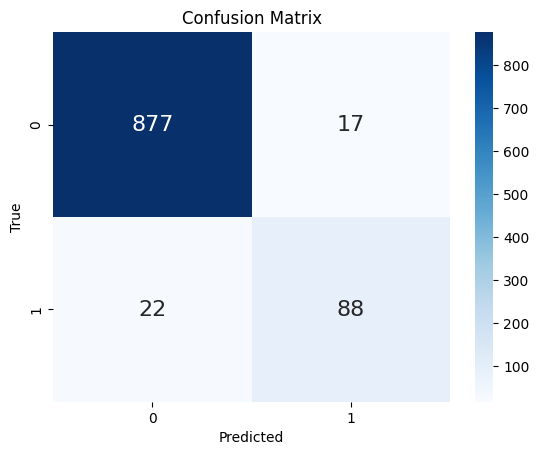

Accuracy: 96.12%
Precision: 0.8381
Recall: 0.8000
F1 Score: 0.8186


In [8]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

threshold = 0.8

Y_pred = model.predict(test_images)
Y_pred_bin_list = []
for val in Y_pred:
    if val > threshold:
        Y_pred_bin_list.append(1)
    else:
        Y_pred_bin_list.append(0)
Y_pred_bin = np.array(Y_pred_bin_list)

# Calculate the confusion matrix
conf_matrix = confusion_matrix(test_masks_bin, Y_pred_bin)

# Display the confusion matrix using a heatmap
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', annot_kws={"size": 16})
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Additional metrics
accuracy = accuracy_score(test_masks_bin, Y_pred_bin)
precision = precision_score(test_masks_bin, Y_pred_bin)
recall = recall_score(test_masks_bin, Y_pred_bin)
f1 = f1_score(test_masks_bin, Y_pred_bin)

print(f"Accuracy: {accuracy * 100:.2f}%")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

In [9]:
%tensorboard --logdir logs/hparam_tuning_24_04_17

UsageError: Line magic function `%tensorboard` not found.
